# Impacts of 100% renewables in European countries
This is a study to try to evaluate the costs and grey energy invloved in switching European countries to 100% renewables mix

We will use historical loads and wind and solar charge factor to try to optimise the system based on the hypothesis that the load factor of those sources can scale linearly.

At this first stage of the study we will consider only those 2 sources since they are easy to model based on historical data

First you shold run the Load data notebook in order to prepare and import the xlsx data into small country/yearly CSV we can query easily 

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('seaborn-poster') #sets the size of the charts
plt.style.use('ggplot')
sns.set_palette(['r','b','y', 'g', 'c', 'm'])

We take as an example France (FR) in the year 2015

In [80]:
data = pd.read_csv('../data/FR_2015.csv').set_index(['Month', 'Day', 'Hour'])
data.describe()

,Consumption (MWh),Wind Charge Factor,Solar Charge Factor
count,"8,760.00","8,760.00","8,760.00"
mean,"54,006.72",0.24,0.13
std,"11,642.45",0.20,0.18
min,"29,589.52",0.00,0.00
25%,"45,230.34",0.09,0.00
50%,"52,568.66",0.17,0.02
75%,"61,807.79",0.34,0.26
max,"91,934.14",0.84,0.68


Now we have the data we need to decide our total capacity in wind and solar.
We start with a naive approach and say we need to have the average wind and solar production to match half of the average consumption

In [81]:
wind_capacity = data.mean()['Consumption (MWh)']/data.mean()['Wind Charge Factor']/2
solar_capacity = data.mean()['Consumption (MWh)']/data.mean()['Solar Charge Factor']/2
print('Capacity in Wind: %.2fGW, Solar: %.2fGW' % (wind_capacity/1000, solar_capacity/1000))

data['Wind production (MWh)'] = data['Wind Charge Factor'] * wind_capacity
data['Solar production (MWh)'] = data['Solar Charge Factor'] * solar_capacity
data['REN production (MWh)'] = data['Wind production (MWh)'] + data['Solar production (MWh)']
data.describe()

Capacity in Wind: 112.69GW, Solar: 201.91GW


,Consumption (MWh),Wind Charge Factor,Solar Charge Factor,Wind production (MWh),Solar production (MWh),REN production (MWh)
count,"8,760.00","8,760.00","8,760.00","8,760.00","8,760.00","8,760.00"
mean,"54,006.72",0.24,0.13,"27,003.36","27,003.36","54,006.72"
std,"11,642.45",0.20,0.18,"22,203.45","36,929.72","41,171.68"
min,"29,589.52",0.00,0.00,54.09,0.00,442.86
25%,"45,230.34",0.09,0.00,"10,192.16",0.00,"17,987.50"
50%,"52,568.66",0.17,0.02,"19,358.89","3,769.23","43,438.19"
75%,"61,807.79",0.34,0.26,"38,762.28","51,667.02","83,241.41"
max,"91,934.14",0.84,0.68,"94,884.97","137,427.59","197,993.31"


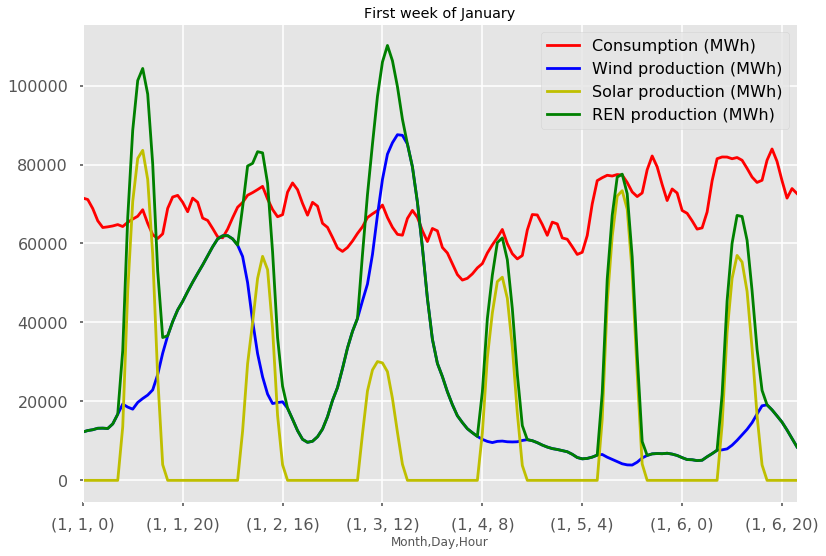

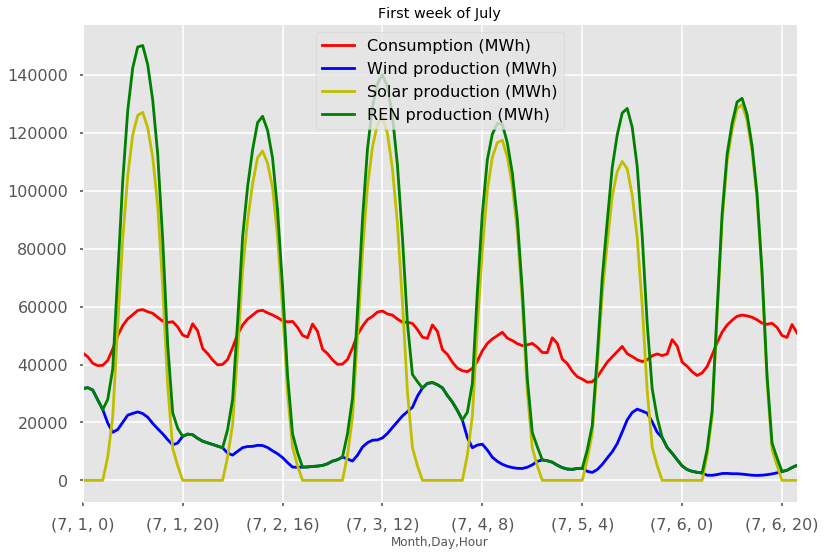

In [82]:
#ig, ax = plt.subplots(221)
cols= ['Consumption (MWh)','Wind production (MWh)', 'Solar production (MWh)', 'REN production (MWh)']
data[cols].head(144).plot(title='First week of January')
data.query('Month > 6')[cols].head(144).plot(title='First week of July')
#plt.show()

In [83]:
data['Balance (MWh)'] = data['REN production (MWh)'] - data['Consumption (MWh)']
data.describe()

,Consumption (MWh),Wind Charge Factor,Solar Charge Factor,Wind production (MWh),Solar production (MWh),REN production (MWh),Balance (MWh)
count,"8,760.00","8,760.00","8,760.00","8,760.00","8,760.00","8,760.00","8,760.00"
mean,"54,006.72",0.24,0.13,"27,003.36","27,003.36","54,006.72",0.00
std,"11,642.45",0.20,0.18,"22,203.45","36,929.72","41,171.68","40,643.19"
min,"29,589.52",0.00,0.00,54.09,0.00,442.86,"-84,120.76"
25%,"45,230.34",0.09,0.00,"10,192.16",0.00,"17,987.50","-31,388.85"
50%,"52,568.66",0.17,0.02,"19,358.89","3,769.23","43,438.19","-10,508.30"
75%,"61,807.79",0.34,0.26,"38,762.28","51,667.02","83,241.41","26,681.71"
max,"91,934.14",0.84,0.68,"94,884.97","137,427.59","197,993.31","142,411.82"


As expected trying to run the system only on wind and solar create a very desequilibrated system and very vulnerable to seasonality. Hence as expected, we need energy storage 

## Let's store it

For this simplistic model we won't make assumption about the kind of storage we use. We will consider the following parameters for our unique storage system:

- Efficiency: The lost of energy involved in storing and restoring electricity. We assumed it is the same in both sense hence the ratio energy_restored/energy_to_store is equal to the square of this factor. To start with we will estimate it to be 0.9
- Capacity: The total amount we can store. Based on what we can find here and there, we will first estimate the storage needs to be 7/8 days of average consumption. (~One week with no wind nor sun). We will take 8 as first approximation

In [84]:
storage_efficiency = 0.9
storage_capacity = data.mean()['Consumption (MWh)'] * 24 * 8
print('Storage capacity: %.2fGWh, efficiency: %.2f' % (storage_capacity/1000, storage_efficiency))

Storage capacity: 10369.29GWh, efficiency: 0.90


In this first approach to modelling storage we will use the simplest startegy possible:

- Whenever we exceed demand and can store it, we store it
- We use storage only when we cannot meet the demand

We also assume that we start with a level of storage of 50%

In [85]:
currently_stored = storage_capacity / 2
stored = []
for index,row in data.iterrows():
    # If balance > 0, we store until we fill the capacity
    # If balance < 0, we restore until it is empty
    currently_stored = \
        max(min(currently_stored + row['Balance (MWh)'] * (storage_efficiency if row['Balance (MWh)'] > 0 else 1/storage_efficiency)
                , storage_capacity), 0)
    stored += [currently_stored]

data['Stored (MWh)'] = stored


In [86]:
data.describe()

,Consumption (MWh),Wind Charge Factor,Solar Charge Factor,Wind production (MWh),Solar production (MWh),REN production (MWh),Balance (MWh),Stored (MWh)
count,"8,760.00","8,760.00","8,760.00","8,760.00","8,760.00","8,760.00","8,760.00","8,760.00"
mean,"54,006.72",0.24,0.13,"27,003.36","27,003.36","54,006.72",0.00,"5,168,136.62"
std,"11,642.45",0.20,0.18,"22,203.45","36,929.72","41,171.68","40,643.19","4,317,659.14"
min,"29,589.52",0.00,0.00,54.09,0.00,442.86,"-84,120.76",0.00
25%,"45,230.34",0.09,0.00,"10,192.16",0.00,"17,987.50","-31,388.85","303,064.93"
50%,"52,568.66",0.17,0.02,"19,358.89","3,769.23","43,438.19","-10,508.30","4,633,058.73"
75%,"61,807.79",0.34,0.26,"38,762.28","51,667.02","83,241.41","26,681.71","9,885,504.44"
max,"91,934.14",0.84,0.68,"94,884.97","137,427.59","197,993.31","142,411.82","10,369,290.46"


OOOps !! our stored capacity get as low as zeros, it means we have not been able to cover all the demand (supposed inflexible) at any time and that we have very likely experienced black out on the grid

Let's try again with doubling the storage capacity, a more optimistic efficiency and starting with battery fully charged 

In [87]:
storage_efficiency = 0.95
storage_capacity = data.mean()['Consumption (MWh)'] * 24 * 8 * 2
print('Storage capacity: %.2fGWh, efficiency: %.2f' % (storage_capacity/1000, storage_efficiency))
currently_stored = storage_capacity
stored = []
black_outs = []
for index,row in data.iterrows():
    currently_stored = \
        max(min(currently_stored + row['Balance (MWh)'] * (storage_efficiency if row['Balance (MWh)'] > 0 else 1/storage_efficiency)
                , storage_capacity), 0)
    stored += [currently_stored]
    if currently_stored == 0:
        black_outs += [index]

data['Stored (MWh)'] = stored
print('Black-outs (Month, Day, Hour)', black_outs)
data.describe()

Storage capacity: 20738.58GWh, efficiency: 0.95
Black-outs (Month, Day, Hour) [(2, 12, 1), (2, 12, 2), (2, 12, 3), (2, 12, 4), (2, 12, 5), (2, 12, 6), (2, 12, 7), (2, 12, 8), (2, 12, 9), (2, 12, 17), (2, 12, 18), (2, 12, 19), (2, 12, 20), (2, 12, 21), (2, 12, 22), (2, 12, 23), (2, 13, 0), (2, 13, 1), (2, 13, 2), (2, 13, 3), (2, 13, 4), (2, 13, 5), (2, 13, 6), (2, 13, 7), (2, 15, 0), (2, 15, 1), (2, 15, 2), (2, 15, 3), (2, 15, 4), (2, 15, 5), (2, 15, 6), (2, 15, 7), (2, 15, 8), (2, 15, 9), (2, 15, 10), (2, 15, 11), (2, 15, 12), (2, 15, 13), (2, 15, 14), (2, 15, 15), (2, 15, 16), (2, 15, 17), (2, 15, 18), (2, 15, 19), (2, 15, 20), (2, 15, 21), (2, 15, 22), (2, 15, 23), (2, 16, 0), (2, 16, 1), (2, 16, 2), (2, 16, 3), (2, 16, 4), (2, 16, 5), (2, 16, 6), (2, 16, 7), (2, 16, 8), (2, 16, 9), (2, 16, 10), (2, 16, 11), (2, 16, 12), (2, 16, 13), (2, 16, 14), (2, 16, 15), (2, 16, 16), (2, 16, 17), (2, 16, 18), (2, 16, 19), (2, 16, 20), (2, 16, 21), (2, 16, 22), (2, 16, 23), (2, 17, 0), (2, 17, 1)

,Consumption (MWh),Wind Charge Factor,Solar Charge Factor,Wind production (MWh),Solar production (MWh),REN production (MWh),Balance (MWh),Stored (MWh)
count,"8,760.00","8,760.00","8,760.00","8,760.00","8,760.00","8,760.00","8,760.00","8,760.00"
mean,"54,006.72",0.24,0.13,"27,003.36","27,003.36","54,006.72",0.00,"11,882,612.97"
std,"11,642.45",0.20,0.18,"22,203.45","36,929.72","41,171.68","40,643.19","7,652,951.44"
min,"29,589.52",0.00,0.00,54.09,0.00,442.86,"-84,120.76",0.00
25%,"45,230.34",0.09,0.00,"10,192.16",0.00,"17,987.50","-31,388.85","4,932,675.83"
50%,"52,568.66",0.17,0.02,"19,358.89","3,769.23","43,438.19","-10,508.30","11,364,898.01"
75%,"61,807.79",0.34,0.26,"38,762.28","51,667.02","83,241.41","26,681.71","20,156,561.56"
max,"91,934.14",0.84,0.68,"94,884.97","137,427.59","197,993.31","142,411.82","20,738,580.92"


Even there we are still experiencing blackouts during some long and cold nights in February, March and December 
So this is maybe an indication we have too much solar power and not enought wind.

Let's try again with doubling the wind capacity and reducing by half the solar one

In [88]:
wind_capacity = data.mean()['Consumption (MWh)']/data.mean()['Wind Charge Factor']
solar_capacity = data.mean()['Consumption (MWh)']/data.mean()['Solar Charge Factor']/4
print('Capacity in Wind: %.2fGW, Solar: %.2fGW' % (wind_capacity/1000, solar_capacity/1000))

data['Wind production (MWh)'] = data['Wind Charge Factor'] * wind_capacity
data['Solar production (MWh)'] = data['Solar Charge Factor'] * solar_capacity
data['REN production (MWh)'] = data['Wind production (MWh)'] + data['Solar production (MWh)']
data['Balance (MWh)'] = data['REN production (MWh)'] - data['Consumption (MWh)']

storage_efficiency = 0.9
storage_capacity = data.mean()['Consumption (MWh)'] * 24 * 8
print('Storage capacity: %.2fGWh, efficiency: %.2f' % (storage_capacity/1000, storage_efficiency))

currently_stored = storage_capacity / 2
stored = []
black_outs = []
for index,row in data.iterrows():
    currently_stored = \
        max(min(currently_stored + row['Balance (MWh)'] * (storage_efficiency if row['Balance (MWh)'] > 0 else 1/storage_efficiency)
                , storage_capacity), 0)
    stored += [currently_stored]
    if currently_stored == 0:
        black_outs += [index]

print('Black-outs (Month, Day, Hour)', black_outs)
data['Stored (MWh)'] = stored
data.describe()


Capacity in Wind: 225.37GW, Solar: 100.95GW
Storage capacity: 10369.29GWh, efficiency: 0.90
Black-outs (Month, Day, Hour) []


,Consumption (MWh),Wind Charge Factor,Solar Charge Factor,Wind production (MWh),Solar production (MWh),REN production (MWh),Balance (MWh),Stored (MWh)
count,"8,760.00","8,760.00","8,760.00","8,760.00","8,760.00","8,760.00","8,760.00","8,760.00"
mean,"54,006.72",0.24,0.13,"54,006.72","13,501.68","67,508.40","13,501.68","8,122,526.52"
std,"11,642.45",0.20,0.18,"44,406.91","18,464.86","46,381.39","44,619.68","2,526,955.33"
min,"29,589.52",0.00,0.00,108.18,0.00,885.71,"-82,176.93","969,314.02"
25%,"45,230.34",0.09,0.00,"20,384.33",0.00,"30,611.62","-20,689.49","6,676,049.99"
50%,"52,568.66",0.17,0.02,"38,717.77","1,884.61","57,431.95","4,634.53","9,274,494.32"
75%,"61,807.79",0.34,0.26,"77,524.57","25,833.51","92,377.68","37,286.81","10,208,451.43"
max,"91,934.14",0.84,0.68,"189,769.94","68,713.80","234,112.27","171,331.69","10,369,290.46"


Indeed this is way better, we even never get below 5% of storage. Which is in fact a requierement for many chemical systems such as the Lithium batteries

## And what about my money ??
Ok it is quite nice to know we can run in 100% renewables but ho much does it actually cost ?

To evaluate the costs even in a simplistic way, we need to introduce a lot of new parameters:
Most of those come from [https://www.irena.org/-/media/Files/IRENA/Agency/Publication/2018/Jan/IRENA_2017_Power_Costs_2018.pdf]

- Investments costs (or CAPEX), the cost of building and demantling all this system:
    - A wind farm is estimated to cost around 1,5M€/MW
    - A solar farm is estimated  to cost around 1,5M€/MW
    - For both we assume the network reinforcement to add 1.5M€/MW
    - We will take the figure for Lithium battery and estimate it costs around 0.2M€/MWh
- Operational costs (or OPEX), the annual cost of operating the system:
    - For both wind and solar statistical figures we can find are around 20k€/MW/yr
    - For storage, we will estimate it around 10k€/GWh/yr
- Lifetime of the equipments:
    - Wind turbines and solar panels are estimated to have a lifetime 25 years
    - Network infrastructure is estimated to live 50 years 
    - Batteries are expected to support 1500 cycles of discharges
    
For producing units will evaluate all the costs yearly so the Capex can be divide by lifetime

In [89]:
wind_lifetime = 25
solar_lifetime = 25
grid_lifetime = 50

# All expressed in M€ per MW per year
wind_capex = 1.5 / wind_lifetime
solar_capex = 1.5 / solar_lifetime
grid_capex = 1.5 / grid_lifetime
wind_opex = 0.02
solar_opex = 0.02


storage_capex = 0.2
storage_opex = 0.00001
storage_cycles = 1500

We start by estimating what is the cost scaled to one year of our production units, including the grid reinforcement costs 

In [90]:
wind_yearly_cost = (wind_capex + wind_opex) * wind_capacity
solar_yearly_cost = (solar_capex + solar_opex) * solar_capacity
grid_yearly_cost = grid_capex * (wind_capacity + solar_capacity)
print('Yearly costs Wind: %.0fMd€, Solar: %.0fMd€, Grid: %.0fMd€' 
      % (wind_yearly_cost/1000, solar_yearly_cost/1000, grid_yearly_cost/1000))

Yearly costs Wind: 18Md€, Solar: 8Md€, Grid: 10Md€


For storage the problem is slightly more complex because the lifetime depends on the number of cycle. Hence we need to calculate an average number of cycle per year.

We first take a look at the yearly time series and distribution of our storage charge level 

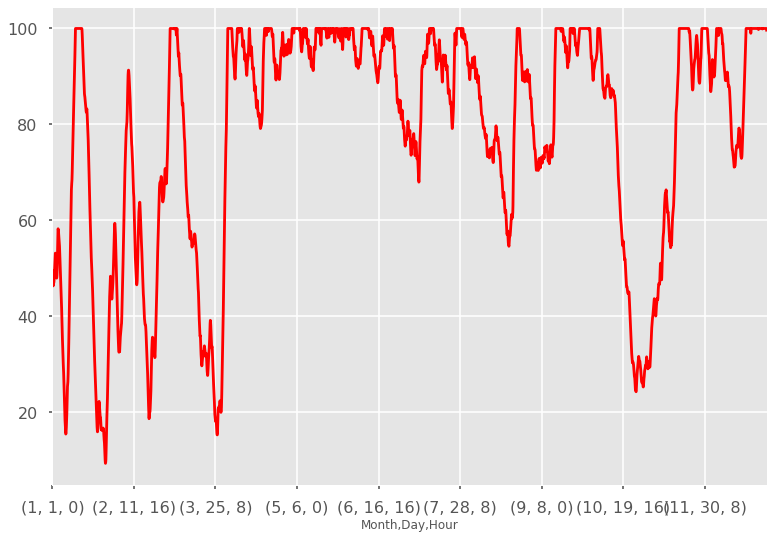

Text(0, 0.5, 'Number of hours')

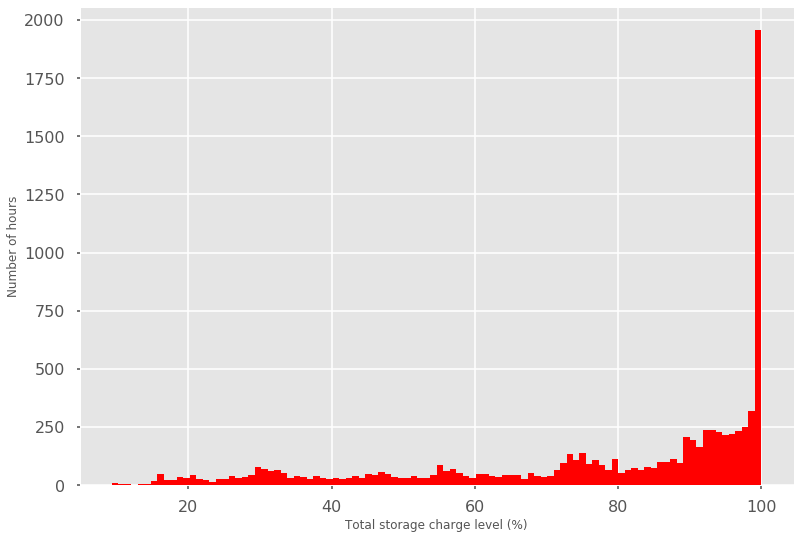

In [91]:
(data['Stored (MWh)']/storage_capacity*100).plot()
plt.show()
(data['Stored (MWh)']/storage_capacity*100).hist(bins=100)
plt.xlabel('Total storage charge level (%)')
plt.ylabel('Number of hours')

We can see that during more than half of the year the storage is fully load and in fact it is very rare that we run below 20% of battery.
This imply that if the battery park is well operated 10% of the batteries will never be used and 10% more should only have a very few cycles per year.
This represent the half the number of cycle by a battery because we can see each percent as a storage unit that is responsible only for this percent of storage and will fully decharge when we get below this centile ad that will only fully charge when we get over this centile again.

In [92]:
import numpy as np
count, division = np.histogram(data['Stored (MWh)']/storage_capacity*100, bins=np.arange(100))
storage_cycles_peryear = np.mean(count)
print('Average storage cycle per year %.0f' % storage_cycles_peryear)

Average storage cycle per year 68


In [93]:
storage_yearly_cost = (storage_capex / storage_cycles * storage_cycles_peryear + storage_opex) * storage_capacity
print('Yearly costs Storage: %.0fMd€' % (storage_yearly_cost/1000))

Yearly costs Storage: 94Md€


Ok now we have all the yearly costs of the system, let sum them up and see what is the resulting price by kWh 

In [94]:
total_yearly_cost = wind_yearly_cost + solar_yearly_cost + grid_yearly_cost + storage_yearly_cost
per_kwh_cost = total_yearly_cost / data.sum()['Consumption (MWh)'] * 1e6 / 1e3 
print('kWh Price: %.3f€' % (per_kwh_cost))

kWh Price: 0.276€


I must say I am quite surprised by this result. This is  This is below the price of the electricity for houshold in Germany.
Obviously this cannot be compared directly since it does not include, maintenance of the transport and distribution network, nor taxes which represents almost half of the price.
But even by doubling this amount we arrive to a high figure but not at all an order of magnitude above the current price as we can regularily heared.

Another important fact underlined by this study is that a large part of the cost is on storage

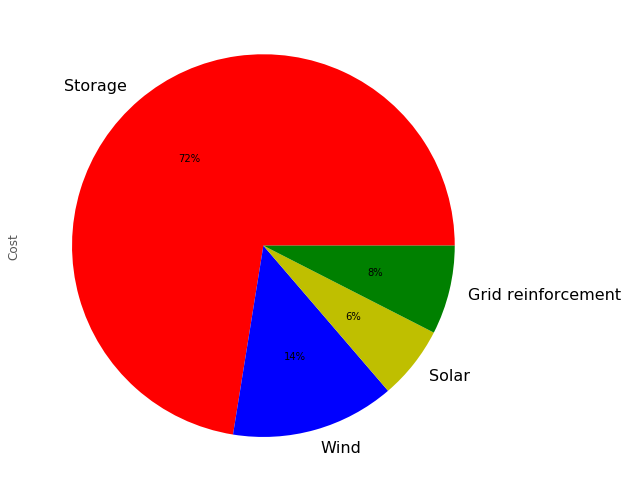

In [95]:
pd.DataFrame({'Concept':['Storage', 'Wind','Solar','Grid reinforcement'],
              'Cost': [storage_yearly_cost, wind_yearly_cost, solar_yearly_cost, grid_yearly_cost]})\
                    .set_index('Concept').plot.pie(y='Cost', legend=False, autopct='%1.0f%%')

Let's now check the impact of having battery storage available at 100€/kWh (Tesla announcement for 2022)

Yearly costs Wind: 18Md€, Solar: 8Md€, Grid: 10Md€, Storage:47Md€
kWh Price: 0.176€


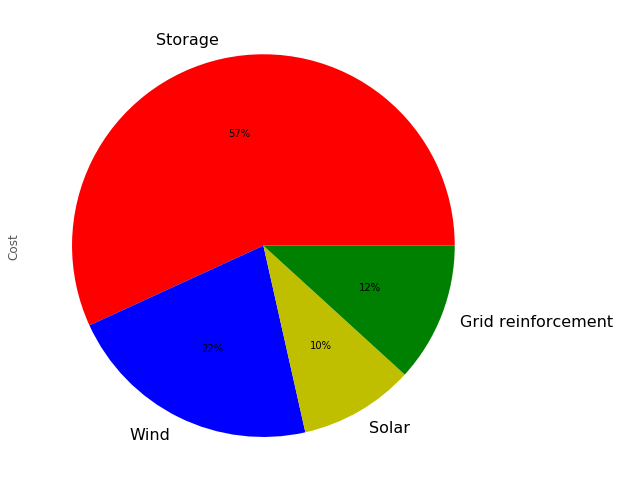

In [96]:
wind_lifetime = 25
solar_lifetime = 25
grid_lifetime = 50

# All expressed in M€ per MW per year
wind_capex = 1.5 / wind_lifetime
solar_capex = 1.5 / solar_lifetime
grid_capex = 1.5 / grid_lifetime
wind_opex = 0.02
solar_opex = 0.02


storage_capex = 0.1
storage_opex = 0.00001
storage_cycles = 1500

wind_yearly_cost = (wind_capex + wind_opex) * wind_capacity
solar_yearly_cost = (solar_capex + solar_opex) * solar_capacity
grid_yearly_cost = grid_capex * (wind_capacity + solar_capacity)
storage_yearly_cost = (storage_capex / storage_cycles * storage_cycles_peryear + storage_opex) * storage_capacity
print('Yearly costs Wind: %.0fMd€, Solar: %.0fMd€, Grid: %.0fMd€, Storage:%.0fMd€' 
      % (wind_yearly_cost/1000, solar_yearly_cost/1000, grid_yearly_cost/1000, storage_yearly_cost/1000))

total_yearly_cost = wind_yearly_cost + solar_yearly_cost + grid_yearly_cost + storage_yearly_cost
per_kwh_cost = total_yearly_cost / data.sum()['Consumption (MWh)'] * 1e6 / 1e3 
print('kWh Price: %.3f€' % (per_kwh_cost))

pd.DataFrame({'Concept':['Storage', 'Wind','Solar','Grid reinforcement'],
              'Cost': [storage_yearly_cost, wind_yearly_cost, solar_yearly_cost, grid_yearly_cost]})\
                    .set_index('Concept').plot.pie(y='Cost', legend=False, autopct='%1.0f%%')

# restore the storage capex for later
storage_capex = 0.2

But one should keep in mind that the wind, solar and storage capacities have been "guessed"

Let's now see if we can optimize them

## Let's optimize all that

To run an optimizer we first need to wrap all our code in a function

In [124]:
def calculate_cost(wind_capacity, solar_capacity, storage_capacity, verbose=False):

    data['Wind production (MWh)'] = data['Wind Charge Factor'] * wind_capacity 
    data['Solar production (MWh)'] = data['Solar Charge Factor'] * solar_capacity
    data['REN production (MWh)'] = data['Wind production (MWh)'] + data['Solar production (MWh)']
    data['Balance (MWh)'] = data['REN production (MWh)'] - data['Consumption (MWh)']
    

    currently_stored = storage_capacity / 2
    stored = []
    for index,row in data.iterrows():
        currently_stored = \
            max(min(currently_stored + row['Balance (MWh)'] * (storage_efficiency if row['Balance (MWh)'] > 0 else 1/storage_efficiency)
                    , storage_capacity), 0)
        stored += [currently_stored]
        if currently_stored == 0:
            # We don't want any black out so we penalize it with a prohibitive kWh cost
            if not verbose:
                print('x', end='')
            else:
                print('Black out', index)
            return 99999999999;

    data['Stored (MWh)'] = stored
    
    wind_yearly_cost = (wind_capex + wind_opex) * wind_capacity
    solar_yearly_cost = (solar_capex + solar_opex) * solar_capacity
    grid_yearly_cost = grid_capex * (wind_capacity + solar_capacity)
    
    count, division = np.histogram(data['Stored (MWh)']/storage_capacity*100, bins=np.arange(100))
    storage_cycles_peryear = np.mean(count)
    print('Cycle per year %i' % storage_cycles_peryear)
    storage_yearly_cost = (storage_capex / storage_cycles * storage_cycles_peryear + storage_opex) * storage_capacity
    
    total_yearly_cost = wind_yearly_cost + solar_yearly_cost + grid_yearly_cost + storage_yearly_cost
    per_kwh_cost = total_yearly_cost / data.sum()['Consumption (MWh)'] * 1e6 / 1e3 
    
    return per_kwh_cost
    
# Check that we are getting expected results
cost = calculate_cost(wind_capacity, solar_capacity, storage_capacity, verbose=True)
print('kWh Price: %.3f€' % (cost))

Cycle per year 68
kWh Price: 0.276€


In [98]:
from scipy.optimize import minimize, fmin

def fopts(args):
    print('.', end='')
    return calculate_cost(args[0],args[1],args[2])


In [58]:
conso_mean = data.mean()['Consumption (MWh)']
wind_capacity = conso_mean/data.mean()['Wind Charge Factor']
solar_capacity = conso_mean/data.mean()['Solar Charge Factor']/4
storage_capacity = conso_mean * 24 * 15
# storage_capex=0.01
# solar_capex=0.1/solar_lifetime
# solar_opex=0.005
init = [wind_capacity, solar_capacity, storage_capacity]
print('Initial Guess Capacity in Wind: %.2fGW, Solar: %.2fGW, Storage: %.2fTWh' % (init[0]/1000, init[1]/1000, init[2]/1e6))
print('Price per kWh :%.3f€' % calculate_cost(wind_capacity, solar_capacity, storage_capacity))
print('Start optimizing')
r = minimize(fopts, init,method='Nelder-Mead',tol=0.001, options={'xatol':1000})
print('')
print(r['message'])
sol=r['x']
print('Optimal Capacity in Wind: %.2fGW, Solar: %.2fGW, Storage: %.2fTWh' % (sol[0]/1000, sol[1]/1000, sol[2]/1e6))
print('Price per kWh :%.3f€' % r['fun'])

Initial Guess Capacity in Wind: 225.37GW, Solar: 100.95GW, Storage: 19.44TWh
Price per kWh :0.429€
Start optimizing
..............Black out on  (1, 23, 2)
..Black out on  (1, 20, 22)
..Black out on  (1, 22, 0)
.Black out on  (1, 21, 15)
..Black out on  (1, 23, 2)
..Black out on  (1, 23, 4)
..Black out on  (1, 23, 12)
..Black out on  (1, 23, 16)
..Black out on  (1, 23, 19)
..Black out on  (1, 23, 21)
...Black out on  (1, 23, 10)
.Black out on  (1, 23, 12)
..Black out on  (1, 23, 21)
...Black out on  (1, 23, 17)
...Black out on  (1, 23, 23)
.Black out on  (1, 23, 18)
..Black out on  (1, 23, 21)
...Black out on  (1, 23, 23)
...Black out on  (1, 23, 23)
....Black out on  (1, 23, 22)
.....Black out on  (1, 23, 23)
.Black out on  (1, 23, 23)
.........Black out on  (1, 23, 18)
..Black out on  (1, 22, 17)
.Black out on  (1, 23, 11)
...Black out on  (1, 23, 8)
..Black out on  (1, 23, 19)
..Black out on  (1, 23, 18)
...Black out on  (1, 23, 16)
.Black out on  (1, 23, 15)
...Black out on  (1, 23,

In [99]:
from pulp import *
import datetime
prob=pulp.LpProblem("Minimum cost",pulp.LpMinimize)
nb_hours=len(data) #1000

# Optimized variables definition
wind_capa=LpVariable("Wind capacity GW",10,250)
solar_capa=LpVariable("Solar capacity GW",10,1000)
storage_capa=LpVariable("Storage capacity GWh",0)

# We will pass stored as capacity at an hour t as a optimization parameter.
# In order to relax the constraint on production we also allow for a parameter losses 
# that represents at an instant t  the amount of production we haven't been able to store 
stored=[]
losses=[]
for i in range (0,nb_hours):
    stored.append(LpVariable("stored("+str(i)+")",0))
    losses.append(LpVariable("losses("+str(i)+")",0))

def total_yearly_cost():
    wind_yearly_cost = (wind_capex + wind_opex) * wind_capa * 1000
    solar_yearly_cost = (solar_capex + solar_opex) * solar_capa * 1000
    grid_yearly_cost = grid_capex * (wind_capa + solar_capa)* 1000
    storage_yearly_cost = (storage_capex / storage_cycles * storage_cycles_peryear + storage_opex) * storage_capa * 1000 * 1.2
    
    return wind_yearly_cost + solar_yearly_cost + grid_yearly_cost + storage_yearly_cost \
        + (storage_capa*nb_hours - lpSum(stored)) *1e-6

# Function to minimize
prob += total_yearly_cost(), "Cost"

wind_cf = data['Wind Charge Factor'].values
solar_cf = data['Solar Charge Factor'].values
consos = data['Consumption (MWh)'].values/1000


def system_equilibrium(i):
    if i> 0:
        return wind_cf[i] * wind_capa + solar_cf[i] * solar_capa - consos[i] + stored[i] - stored[i-1] - losses[i]
    else:
        return wind_cf[i] * wind_capa + solar_cf[i] * solar_capa - consos[i] + stored[0] - storage_capa / 2 - losses[0]

time_start = datetime.datetime.now()
    
# Constraints
for i in range(1,nb_hours):
    # system equilibrium at all time
    prob+= system_equilibrium(i) == 0 
    # storage won't go above capacity and not below 5%
    prob+= stored[i]<=storage_capa
    prob+= stored[i]>=0.10*storage_capa
    
print('time sprent creating constraints', datetime.datetime.now()-time_start)

time sprent creating constraints 0:00:01.520628


In [100]:
time_start = datetime.datetime.now()
prob.solve()
print('time sprent solving problem',datetime.datetime.now()-time_start)
print ("Status:", LpStatus[prob.status])

time sprent solving problem 0:00:06.624964
Status: Optimal


In [101]:
def find_var_index(var_string):
    return int(''.join([s for s in var_string if s.isdigit()]))
charges_best=[None]*nb_hours
discharges_best=[None]*nb_hours
stored_best=[None]*nb_hours
losses_best=[None]*nb_hours
for v in prob.variables():
    if v.name == 'Storage_capacity_GWh':
        storage_best=v.varValue
    elif v.name == 'Solar_capacity_GW':
        solar_best=v.varValue
    elif v.name == 'Wind_capacity_GW':
        wind_best=v.varValue
    elif v.name.startswith('stored'):
        ind = find_var_index(v.name)
        stored_best[ind]=v.varValue
    elif v.name.startswith('losses'):
        ind = find_var_index(v.name)
        losses_best[ind]=v.varValue

print('Optimal Capacity in Wind: %.2fGW, Solar: %.2fGW, Storage: %.2fTWh' % (wind_best, solar_best, storage_best/1000))

Optimal Capacity in Wind: 250.00GW, Solar: 356.84GW, Storage: 4.46TWh


In [102]:
print('Price per kWh :%.3f€' % calculate_cost(wind_best*1000, solar_best*1000, storage_best*1000*1.2))

Price per kWh :0.193€


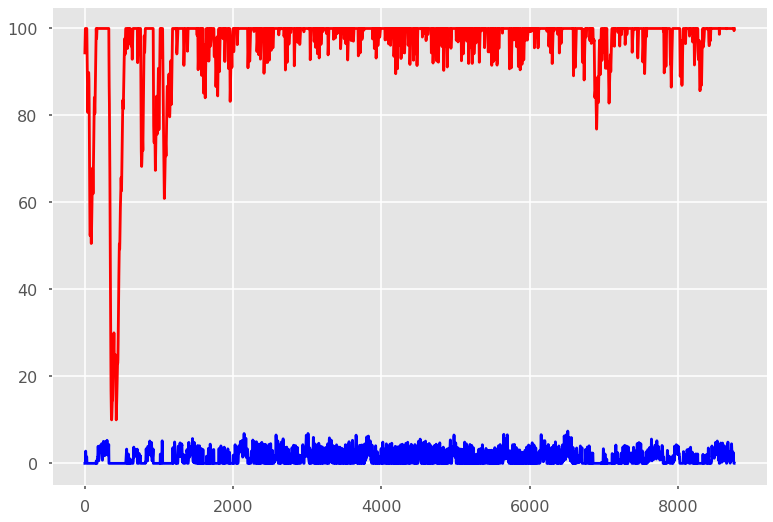

In [103]:

#plt.plot(charges_best)
#plt.plot(discharges_best)
plt.plot(np.array(stored_best)/storage_best*100)
plt.plot(np.array(losses_best[1:])/storage_best*100)

In [120]:
init = [wind_best*1000, solar_best*1000, storage_best*1200]
print('Initial Guess Capacity in Wind: %.2fGW, Solar: %.2fGW, Storage: %.2fTWh' % (init[0]/1000, init[1]/1000, init[2]/1e6))
print('Price per kWh :%.3f€' % calculate_cost(init[0], init[1], init[2]))
print('Start optimizing')
def apply_constraint(inputs):
    return 250000 - inputs[0]

my_constraints = ({'type': 'ineq', "fun": apply_constraint })
#my_constraints = (init[0] <= 250)
r = minimize(fopts, init,method='COBYLA', tol=0.001, constraints= my_constraints, options={'xatol':1000})
print('')
print(r['message'])
sol=r['x']
print('Optimal Capacity in Wind: %.2fGW, Solar: %.2fGW, Storage: %.2fTWh' % (sol[0]/1000, sol[1]/1000, sol[2]/1e6))
print('Price per kWh :%.3f€' % r['fun'])

Initial Guess Capacity in Wind: 250.00GW, Solar: 356.84GW, Storage: 5.35TWh
Price per kWh :0.193€
Start optimizing
.

/home/nico/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: OptimizeWarning: Unknown solver options: xatol
  # Remove the CWD from sys.path while we load stuff.


.................................................
Optimization terminated successfully.
Optimal Capacity in Wind: 249.99GW, Solar: 356.83GW, Storage: 5.35TWh
Price per kWh :0.193€


In [125]:
print('Price per kWh :%.3f€' % calculate_cost(sol[0], sol[1], sol[2], verbose=True))

Cycle per year 34
Price per kWh :0.193€


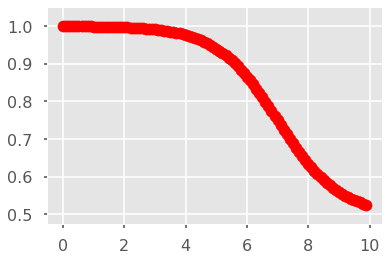

In [269]:
x = np.arange(0,10,0.1)
k=1
y = (1+1/(1+np.exp(k*(x-7))))*0.5
plt.scatter(x,y)

# We introduce a decay in load factor depending on installed capacity
wind_actual_capa = (1+1/(1+np.exp(k*(wind_capa*1/10.-7))))*0.5*wind_capa